## Generador de Clickbaits con Seq2Seq

### Objetivos:
1. Preparar dataset: titular normal → titular clickbait
3. Entrenar modelo Seq2Seq encoder-decoder para generar titulos con estilo clickbait automáticamente a partir del titular, es decir sin revelar el contenido y fomentar el click a abrir la noticia.

### ¿Qué es un clickbait?
Un título sensacionalista diseñado para atraer clicks:
- Crea curiosidad sin revelar todo
- Usa palabras emocionales
- Promete información impactante

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

2025-11-10 13:13:05.789765: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 13:13:05.789961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 13:13:05.820951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 13:13:06.526389: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [3]:
df = pd.read_csv(
    "noticias_unificadas.tsv",
    encoding="utf-8",
    sep="\t",
    dtype={"fecha": "string", "titulo": "string", "contenido": "string", "seccion": "string"},
    quoting=0,
    na_filter=False
)

print(f"Total de noticias: {len(df)}")
print(f"\nPrimeros titulares:")

df.head(5)

Total de noticias: 37746

Primeros titulares:


,fecha,titulo,contenido,seccion,link
0,2025-11-09,jueces rechazan intento de afectacion a la ind...,desde la ciudad de tacna jueces y juezas de to...,Política,https://diariocorreo.pe/politica/jueces-rechaz...
1,2025-11-09,liga lo gritan los churres y todo el pueblo de...,alianza atletico le saco lustre a su clasifica...,Deportes,https://diariocorreo.pe/deportes/alianza-atlet...
2,2025-11-09,proponen sancionar con hasta anos de carcel a ...,la congresista elizabeth medina hermosillo de ...,Política,https://diariocorreo.pe/politica/proponen-sanc...
3,2025-11-09,este lunes inicia la semana de representacion ...,desde este lunes hasta el viernes de noviembre...,Política,https://diariocorreo.pe/politica/este-lunes-in...
4,2025-11-09,seleccion peruana evalua reprogramacion de par...,la federacion peruana de futbol fpf informo qu...,Deportes,https://diariocorreo.pe/deportes/seleccion-per...


In [4]:

from utils.utils import clean_text

df['titulo_limpio'] = df['titulo'].fillna("").map(clean_text)

df_filtered = df[
    (df['titulo_limpio'].str.len() >= 20) & 
    (df['titulo_limpio'].str.len() <= 150)
].copy()

print(f"Titulares válidos: {len(df_filtered)}")
print(f"\nEstadísticas de longitud:")
print(df_filtered['titulo_limpio'].str.len().describe())

Titulares válidos: 37670

Estadísticas de longitud:
count    37670.000000
mean        76.080196
std         17.423963
min         20.000000
25%         65.000000
50%         76.000000
75%         87.000000
max        145.000000
Name: titulo_limpio, dtype: float64


### Generación de Dataset de Clickbaits

Se uso un modelo LLM basado en Ollama para transformar titulares normales en clickbait y generar un dataset sintentico

In [5]:
from clickbait_dataset_builder import generate_clickbait_ollama

In [6]:

import os
import time

DATASET_FILE = 'dataset_clickbaits.csv'

if os.path.exists(DATASET_FILE):
    print(f"Dataset existente encontrado: '{DATASET_FILE}'")
    df_sample = pd.read_csv(DATASET_FILE, encoding='utf-8')

    existing_titles = set(df_sample['titulo_limpio'].tolist())

    add_more = False
    additional_size = 500
    
    if not add_more:
        print(f"\n Usando dataset existente: {len(df_sample)} ejemplos")
else:
    df_sample = pd.DataFrame(columns=['titulo_limpio', 'clickbait'])
    existing_titles = set()
    add_more = True
    additional_size = 500

if add_more:
    df_available = df_filtered[~df_filtered['titulo_limpio'].isin(existing_titles)].copy()
    
    if len(df_available) == 0:
        print("\nNo hay más titulares únicos disponibles")
    else: 
        actual_size = min(additional_size, len(df_available))
        df_to_process = df_available.sample(n=actual_size, random_state=42).copy()
        
        print(f"\nProcesando {len(df_to_process)} titulares con Ollama...")

        failed = 0
        
        for idx, (row_idx, row) in enumerate(df_to_process.iterrows(), 1):

            clickbait = generate_clickbait_ollama(row['titulo_limpio'])

            new_row = pd.DataFrame([{
                'titulo_limpio': row['titulo_limpio'],
                'clickbait': clickbait
            }])

            df_sample = pd.concat([df_sample, new_row], ignore_index=True)

            if idx == 1 and len(existing_titles) == 0:
                new_row.to_csv(DATASET_FILE, mode='w', index=False, encoding='utf-8')
            else:
                new_row.to_csv(DATASET_FILE, mode='a', index=False, header=False, encoding='utf-8')

            if idx % 10 == 0:
                print(f"Progreso: {idx}/{len(df_to_process)} | Total acumulado: {len(df_sample)}")
            
            time.sleep(0.25)

        print(f"Proceso completado")


Dataset existente encontrado: 'dataset_clickbaits.csv'

 Usando dataset existente: 1301 ejemplos


In [7]:
print("EJEMPLOS DE TITULARES vs CLICKBAITS")
for i in range(10):
    print(f"\n{i+1}.")
    print(f"Original:  {df_sample.iloc[i]['titulo_limpio']}")
    print(f"Clickbait: {df_sample.iloc[i]['clickbait']}")

EJEMPLOS DE TITULARES vs CLICKBAITS

1.
Original:  inauguran cade ejecutivos 2024 en arequipa
Clickbait: ¡Descubre quiénes son los 5 ejecutivos que cambiarán el destino de Arequipa en 2024!

2.
Original:  denuncian que congresista maria acuna se niega a pagar impuestos por mas de s/3 millones a la sunat
Clickbait: ¡Congresista de $3 MILLONES! ¿Paga sus impuestos o es un fraude?

3.
Original:  ¡regresan los iconos del k-pop! v y rm de bts concluyen su servicio militar
Clickbait: ¡RM y V regresan del frente! ¿Con qué sorpresa vuelve el rey del K-Pop?

4.
Original:  ministerio publico inicia diligencias preliminares contra jose domingo perez
Clickbait: ¡EXPOSADO! El Ministerio Público se lanzó a la persecución de Jose Díaz... y reveló un secreto que cambiará tu vida para siempre!

5.
Original:  ley mape: ministro jorge montero no acudio a comision de energia y minas
Clickbait: ¡El Ministro de Energía se Escabulla! ¡Montero evita la Comisión de Energía por más de 1000 días!

6.
Original:  

### Preparar Datos para Seq2Seq

In [8]:
df_sample['input_text'] = df_sample['titulo_limpio']
df_sample['target_text'] = '<start> ' + df_sample['clickbait'] + ' <end>'

print("Tokens especiales agregados:")
print(f"\nInput:  {df_sample['input_text'].iloc[0]}")
print(f"Target: {df_sample['target_text'].iloc[0]}")

Tokens especiales agregados:

Input:  inauguran cade ejecutivos 2024 en arequipa
Target: <start> ¡Descubre quiénes son los 5 ejecutivos que cambiarán el destino de Arequipa en 2024! <end>


In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_sample, 
    test_size=0.1, 
    random_state=42
)

print(f"Train: {len(train_df)} ejemplos")
print(f"Test:  {len(test_df)} ejemplos")

Train: 1170 ejemplos
Test:  131 ejemplos


In [10]:
input_tokenizer = Tokenizer(filters='', lower=True)
input_tokenizer.fit_on_texts(train_df['input_text'])

target_tokenizer = Tokenizer(filters='', lower=True)
target_tokenizer.fit_on_texts(train_df['target_text'])

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print(f"Input vocabulary size:  {input_vocab_size}")
print(f"Target vocabulary size: {target_vocab_size}")

Input vocabulary size:  5102
Target vocabulary size: 5333


In [11]:
encoder_input_train = input_tokenizer.texts_to_sequences(train_df['input_text'])
encoder_input_test = input_tokenizer.texts_to_sequences(test_df['input_text'])

decoder_input_train = target_tokenizer.texts_to_sequences(train_df['target_text'])
decoder_input_test = target_tokenizer.texts_to_sequences(test_df['target_text'])

max_encoder_len = max([len(seq) for seq in encoder_input_train])
max_decoder_len = max([len(seq) for seq in decoder_input_train])

print(f"Max encoder length: {max_encoder_len}")
print(f"Max decoder length: {max_decoder_len}")

Max encoder length: 26
Max decoder length: 34


In [12]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_encoder_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_encoder_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_decoder_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_decoder_len, padding='post')

decoder_output_train = np.zeros_like(decoder_input_train)
decoder_output_train[:, :-1] = decoder_input_train[:, 1:]

decoder_output_test = np.zeros_like(decoder_input_test)
decoder_output_test[:, :-1] = decoder_input_test[:, 1:]

print("Shapes:")
print(f"  Encoder input: {encoder_input_train.shape}")
print(f"  Decoder input: {decoder_input_train.shape}")
print(f"  Decoder output: {decoder_output_train.shape}")
print(f"  Encoder test: {encoder_input_test.shape}")
print(f"  Decoder test input: {decoder_input_test.shape}")
print(f"  Decoder test output: {decoder_output_test.shape}")

Shapes:
  Encoder input: (1170, 26)
  Decoder input: (1170, 34)
  Decoder output: (1170, 34)
  Encoder test: (131, 26)
  Decoder test input: (131, 34)
  Decoder test output: (131, 34)


### Construir Modelo Seq2Seq

In [13]:
embedding_dim = 512
latent_dim = 1024

# Encoder
encoder_inputs = Input(shape=(max_encoder_len,), name='encoder_input')
encoder_embedding = Embedding(
    input_vocab_size, 
    embedding_dim, 
    mask_zero=True,
    name='encoder_embedding'
)(encoder_inputs)

encoder_lstm = LSTM(
    latent_dim, 
    return_state=True,
    name='encoder_lstm'
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_decoder_len,), name='decoder_input')
decoder_embedding = Embedding(
    target_vocab_size, 
    embedding_dim,
    mask_zero=True,
    name='decoder_embedding'
)(decoder_inputs)

decoder_lstm = LSTM(
    latent_dim, 
    return_sequences=True,
    return_state=True,
    name='decoder_lstm'
)
decoder_outputs, _, _ = decoder_lstm(
    decoder_embedding,
    initial_state=encoder_states
)

decoder_dense = Dense(
    target_vocab_size, 
    activation='softmax',
    name='decoder_dense'
)
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo
model = Model(
    [encoder_inputs, decoder_inputs], 
    decoder_outputs
)

model.summary()

2025-11-10 13:13:08.673089: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 26, 512)   │  2,612,224 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 26)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 34, 512)   │  2,730,496 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 1024),    │  6,295,552 │ encoder_embeddin… │
│                     │ (None, 1024),     │            │ not_equal[0][0]   │
│                     │ (None, 1024)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 34,       │  6,295,552 │ decoder_embeddin… │
│                     │ 1024), (None,     │            │ encoder_lstm[0][… │
│                     │ 1024), (None,     │            │ encoder_lstm[0][… │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 34, 5333)  │  5,466,325 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,400,149 (89.26 MB)

 Trainable params: 23,400,149 (89.26 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo compilado")

Modelo compilado


In [15]:
print("Entrenando modelo...")

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Entrenar
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=64,
    epochs=20,
    validation_split=0.1,
    callbacks=[reduce_lr],
    verbose=1
)

print("\nEntrenamiento completado")

Entrenando modelo...
Epoch 1/20


2025-11-10 13:13:11.580866: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0725 - loss: 7.3249 - val_accuracy: 0.1456 - val_loss: 6.6310 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0725 - loss: 7.3249 - val_accuracy: 0.1456 - val_loss: 6.6310 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1535 - loss: 6.2757 - val_accuracy: 0.1578 - val_loss: 6.4771 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1535 - loss: 6.2757 - val_accuracy: 0.1578 - val_loss: 6.4771 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1590 - loss: 6.0308 - val_accuracy: 0.1725 - val_loss: 6.3305 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1590 - loss: 6.0308 - val_accuracy: 0.1725 - val_loss: 6.3305 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1758 - loss: 5.6837 - val_accuracy: 0.1819 - va

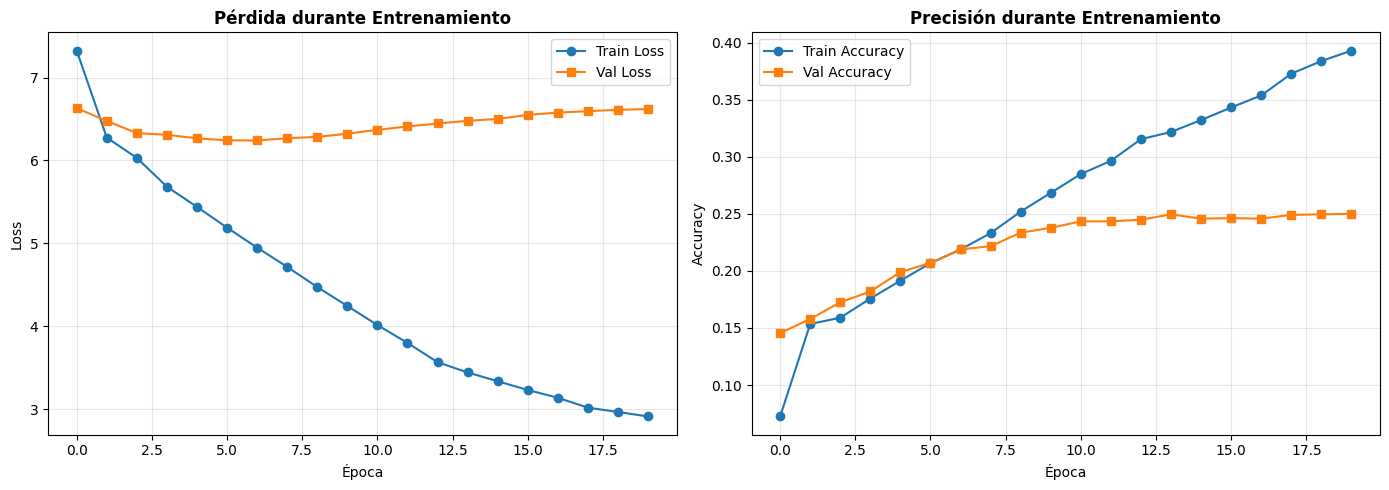

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss', marker='o')
ax1.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax1.set_title('Pérdida durante Entrenamiento', fontsize=12, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax2.set_title('Precisión durante Entrenamiento', fontsize=12, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Inferencia

In [17]:
# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model para inferencia
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Input para decoder (una palabra a la vez)
decoder_inputs_single = Input(shape=(1,), name='decoder_input_single')

# Obtener la capa de embedding del modelo original
decoder_embedding_layer = model.get_layer('decoder_embedding')
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_single)

# Obtener la capa LSTM del decoder
decoder_lstm_layer = model.get_layer('decoder_lstm')
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_layer(
    decoder_embedding_inf,
    initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

# Obtener la capa dense del decoder
decoder_dense_layer = model.get_layer('decoder_dense')
decoder_outputs_inf = decoder_dense_layer(decoder_outputs_inf)

# Modelo de inferencia del decoder
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

In [18]:
target_index_to_word = {index: word for word, index in target_tokenizer.word_index.items()}
target_index_to_word[0] = ''

def generate_clickbait(input_text, max_length=50):
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_len, padding='post')
    
    states_value = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1, 1))
    
    start_token_index = target_tokenizer.word_index.get('<start>', 1)
    target_seq[0, 0] = start_token_index

    stop_condition = False
    decoded_sentence = []
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value,
            verbose=0
        )
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_index_to_word.get(sampled_token_index, None)
        
        if sampled_word is None or sampled_word == '':
            break
        
        if sampled_word == '<end>' or len(decoded_sentence) >= max_length:
            stop_condition = True
        elif sampled_word == '<start>':
            pass
        else:
            decoded_sentence.append(sampled_word)
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        states_value = [h, c]

    result = ' '.join(decoded_sentence)

    if not result:
        return "[El modelo no pudo generar un clickbait]"
    return result

print(f"Vocabulario target: {len(target_index_to_word)} palabras")

Vocabulario target: 5333 palabras


### Pruebas

In [19]:
print("GENERACIÓN DE CLICKBAITS - EJEMPLOS DEL TEST SET")

for i in range(10):
    original = test_df['titulo_limpio'].iloc[i]
    real_clickbait = test_df['clickbait'].iloc[i]
    generated = generate_clickbait(original)
    
    print(f"\n{i+1}.")
    print(f"   Original:         {original}")
    print(f"   Clickbait Real:   {real_clickbait}")
    print(f"   Clickbait Gen:    {generated}")

GENERACIÓN DE CLICKBAITS - EJEMPLOS DEL TEST SET

1.
   Original:         maricarmen marin brinda espectaculo por navidad a familias piuranas
   Clickbait Real:   ¡Descubre qué sorpresas sorprenderá Maricarmen Marin en Navidad! 500 familias Piuranas se preparan para un espectáculo único.
   Clickbait Gen:    ¡descubre el secreto que hace que hace que cambiarán tu vida para siempre!

1.
   Original:         maricarmen marin brinda espectaculo por navidad a familias piuranas
   Clickbait Real:   ¡Descubre qué sorpresas sorprenderá Maricarmen Marin en Navidad! 500 familias Piuranas se preparan para un espectáculo único.
   Clickbait Gen:    ¡descubre el secreto que hace que hace que cambiarán tu vida para siempre!

2.
   Original:         shirley cherres clama por ayuda tras complicaciones de manga gastrica
   Clickbait Real:   Shirley Cherres en el borde: ¿6 meses de ayuno le han roto la vida?
   Clickbait Gen:    ¡descubre el secreto que hace que hace que cambiarán tu vida para siempre!

In [20]:
print("Evaluando modelo en test set...")

test_loss, test_acc = model.evaluate(
    [encoder_input_test, decoder_input_test],
    decoder_output_test,
    verbose=0
)

print(f"\nResultados en Test Set:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f}")

Evaluando modelo en test set...

Resultados en Test Set:
   Loss: 5.2776
   Accuracy: 0.2599

Resultados en Test Set:
   Loss: 5.2776
   Accuracy: 0.2599


In [21]:
model.save('seq2seq_clickbait_generator.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')